In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer # Bag of Words için
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pickle
import os

In [2]:
def load_dataset(path, rows=2000):
    df = pd.read_csv(path)
    df = df.drop(columns=['id', 'text'])
    df = df.head(rows)
    X = df['roots']
    y = df['label']
    return X, y, df

In [3]:
def classify(X, y, modelType="SVM", vectorizerType="BOW", save=False ):
    # Eğitim ve test veri setlerini ayır
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Eksik verileri doldur
    X_train = np.where(pd.isna(X_train), '', X_train)
    X_test = np.where(pd.isna(X_test), '', X_test)

    if(vectorizerType=="BOW"):
        # Bag of Words vektörleştirme
        vectorizer = CountVectorizer()
        #vectorizer = CountVectorizer(max_features=500)   # Bag of Words için CountVectorizer kullanıyoruz
        X_train_vectorized = vectorizer.fit_transform(X_train)
        X_test_vectorized = vectorizer.transform(X_test)
    elif(vectorizerType=="TF"):
        # Vectorize the text data using TF-IDF
        vectorizer = TfidfVectorizer()
        X_train_vectorized = vectorizer.fit_transform(X_train)
        X_test_vectorized = vectorizer.transform(X_test)
    else:
        print("Yanlis vectorizer adi!")
        return

    # Initialize Model
    classifier = None
    if(modelType=="SVM"):
        # Create and train the SVM model
        classifier = SVC(kernel='linear', probability=True, max_iter=300,tol=0.001)
        # params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': [0.001, 0.01, 0.1]}
        # classifier = GridSearchCV(SVC(), params, cv=3, n_jobs=4)
    elif(modelType=="LR"):
        # Logistic Regression modelini oluştur ve eğit
        classifier = LogisticRegression(max_iter=1000)
        params = {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver': ['newton-cg', 'saga']}
        classifier = GridSearchCV(LogisticRegression(), params, cv=3, n_jobs=4)
    elif(modelType=="MNB"):
        #MultinomialNB modeli
        classifier = MultinomialNB()
        params = {'alpha': [0.1, 0.7, 1.0, 2.0]}
        classifier = GridSearchCV(MultinomialNB(), params, cv=3, n_jobs=4)
    elif (modelType == "DT"):
        # Decision Tree modeli
        classifier = DecisionTreeClassifier(random_state=42)
        params = {'criterion': ['gini', 'entropy'], 'max_depth': [10, 50, 100], 'min_samples_split': [2, 5, 10]}
        classifier = GridSearchCV(DecisionTreeClassifier(), params, cv=3, n_jobs=4)
    elif (modelType == "KNN"):
        # K-Neighbors modeli
        classifier = KNeighborsClassifier()
        params = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
        classifier = GridSearchCV(KNeighborsClassifier(), params, cv=3, n_jobs=4)
    elif (modelType == "RF"):
        # Random Forest modeli
        classifier = RandomForestClassifier(random_state=42)
        params = {'n_estimators': [50, 100, 150], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 50, 100]}
        classifier = GridSearchCV(RandomForestClassifier(), params, cv=3, n_jobs=4)
        
    else:
        print("Yanlis model adi!")
        return

    classifier.fit(X_train_vectorized, y_train)
    # Make predictions
    y_pred = classifier.predict(X_test_vectorized)

    print("\nModel Performansi:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    save_path = f'models/{modelType}_{vectorizerType}'
    model_path = f'{save_path}_model.pkl'
    vectorizer_path = f'{save_path}_vectorizer.pkl'

    # Modeli kaydetme
    if save:
        with open(model_path, 'wb') as file:
            pickle.dump(classifier, file)
            
        with open(vectorizer_path, 'wb') as vectorizer_file:
            pickle.dump(vectorizer, vectorizer_file)

    return y_test, y_pred, classifier

In [16]:
def create_matrix(y_test, y_pred, classifier):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


Veri yuklendi!

Model isleniyor...

Model Performansi:
Accuracy: 0.8955974842767296
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      6756
           1       0.95      0.82      0.88      5964

    accuracy                           0.90     12720
   macro avg       0.91      0.89      0.89     12720
weighted avg       0.90      0.90      0.89     12720



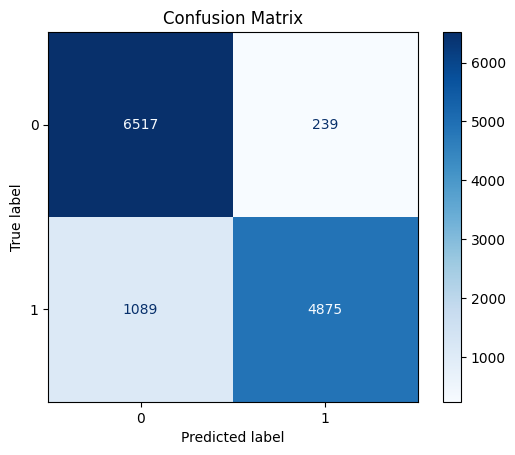

In [5]:
if __name__ == "__main__":
    X, y, df = load_dataset(path  = 'datasets/turkish_dataset/turkce_cumleler_kokler_corrected_50k.csv', rows = 2000)
    print("\nVeri yuklendi!")
    print("\nModel isleniyor...")
    #y_test, y_pred, classifier = classify(X, y, "LOG", "BOW")
    y_test, y_pred, classifier = classify(X, y, "SVM", "BOW", save=True) #Modeli kaydetmek için
    #Modeller: SVM, LOG, MNB, DT, KNN, RF
    #Vektörleştiriciler: BOW, TF
    if y_test is not None and y_pred is not None:
        create_matrix(y_test, y_pred, classifier)

In [6]:
# Kaydedilen modeli yükleme
# import joblib
# loaded_model = joblib.load("svm_model.pkl")
# predictions = loaded_model.predict(new_data)